In [12]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.utils import *
import nibabel as nib
from scipy.stats import wilcoxon, shapiro, mannwhitneyu

In [161]:
model_path = os.path.join(fits_dir, 'fits_inversed', 'subj01', 'fits_subj01_train_V1_inversed.npy')
model = np.load(model_path, allow_pickle=True)
model.shape

(33797, 9)

In [4]:
"""
This is the correct way, I think: take from each source roi and then check the sampling values 
"""

columns = ["x0", "y0", "sigma", "slope", "intercept", "test_var_explained", "var_explained", "mds_ecc", "mds_ang"] #, "roi", "fit_with"]  # replace fit with with the best explain? just one value 
results = -np.ones((2, len(subj_list), len(rois.keys()), len(rois.keys())))
z_stats = np.ones((2, len(subj_list), len(rois.keys()), len(rois.keys())))
p_values = np.ones((2, len(subj_list), len(rois.keys()), len(rois.keys())))

print(results.shape)
"""
This returns a 4D array containing the average test_var_explain for all hemis (dim=0), all subject (dim=1) and for all ROI (dim=3)and their sampling space (dim=4)
The way to read each table is the following: for each row, each value is how well that ROI can be explain by another (or it's own) ROI sampling space. So,
index [0,2] for example is how well V1 is explained by V3 
"""

for i, sub in enumerate(subj_list):
    if sub == 'subj06' or sub == 'subj08':
        maskdata_file = os.path.join(mask_dir, sub, f'short.reduced.nans.{sub}.testrois.npy')
    else:
        maskdata_file = os.path.join(mask_dir, sub, f'short.reduced.{sub}.testrois.npy')
            # find cutoff for lh and rh division
    if sub == 'subj06' or sub == 'subj08':
        mask_cutoff_file = os.path.join(mask_dir, sub, f'lh.{sub}.nans.testrois.mgz')
        mask = nib.load(mask_cutoff_file).get_fdata().squeeze()
        mask = mask[mask != 0]
        cutoff = mask.shape
    else: 
        mask_cutoff_file = os.path.join(mask_dir, sub, f'lh.short.reduced.{sub}.testrois.npy')
        mask = np.load(mask_cutoff_file)
        cutoff = mask.shape
    maskdata = np.load(maskdata_file, allow_pickle=True).astype(int)
    n_voxels = maskdata.shape[0]
    belongs = []
    for k in maskdata:
        belongs.append(sior[k])

    belongs = np.array(belongs)

    fits_subj = np.zeros((len(rois.keys()), n_voxels, len(columns)))

    for j, roi in enumerate(rois.keys()):

  
        fits_path = os.path.join(fits_dir, 'fits_inversed', sub, f'fits_{sub}_train_{roi}_inversed.npy')

        fits_matrix = np.load(fits_path, allow_pickle=True)
        
        fits_subj[j] = fits_matrix

    for k, roi in enumerate(rois.keys()):

        roi_values_lh = fits_subj[:, :cutoff[0], 5][:,maskdata[:cutoff[0]] == k+1]  # that is unfortunately correct
        roi_values_rh = fits_subj[:, cutoff[0]:, 5][:,maskdata[cutoff[0]:] == k+1]  # right?????? 

        means_roi_lh = np.mean(roi_values_lh, axis=1)
        means_roi_rh = np.mean(roi_values_rh, axis=1)
        results[0, i, k] = means_roi_lh
        results[1, i, k] = means_roi_rh 

print(results.shape)
        
        

(2, 8, 12, 12)
(2, 8, 12, 12)


In [165]:
result_path = os.path.join(proj_dir, 'results', 'results_bestROI_all.npy')
np.save(result_path, results)

## OUTPUT SOME RESULTS 

In [166]:
subj01_results_lh = pd.DataFrame(results[0, 0], columns=rois.keys(), index=rois.keys())
subj01_results_lh["best_roi"]  = subj01_results_lh.idxmax(axis=1)
subj01_results_lh

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2,best_roi
V1,0.033243,0.025535,0.022014,0.022666,0.019000,0.029126,0.004986,0.006003,0.007554,0.000999,0.000284,0.007840,V1
V2,0.026296,0.022197,0.025926,0.027970,0.027533,0.035674,0.011608,0.010119,0.010915,0.002009,0.001517,0.011028,VO-2
V3,0.021743,0.020644,0.027156,0.029576,0.032470,0.042959,0.017759,0.013326,0.012100,0.003855,0.003154,0.017905,VO-2
hV4,0.012059,0.006248,0.018298,0.011921,0.020624,0.019990,0.016739,0.010516,0.009089,0.003690,0.004993,0.012217,VO-1
VO-1,0.008769,0.003525,0.007543,0.006619,0.010306,0.011851,0.011089,0.045346,0.029002,0.023794,0.034745,0.014096,PHC-2
VO-2,0.008564,-0.000303,0.008983,-0.000675,0.012846,0.004781,0.009227,0.038280,0.042337,0.025387,0.023967,0.011651,LO-1
PHC-1,-0.003675,-0.004402,-0.002112,-0.003459,-0.000152,-0.001541,0.000299,0.034491,0.017788,0.035481,0.043798,0.016510,TO-1
PHC-2,-0.001102,-0.001691,-0.000741,-0.000895,0.000987,0.000793,0.001138,0.042961,0.023905,0.041008,0.061782,0.013140,TO-1
LO-1,-0.000367,0.004252,0.004504,0.011301,0.006260,0.017687,0.003811,0.010487,0.005483,0.012282,0.011670,0.010243,VO-2
LO-2,-0.002476,-0.001175,-0.000670,0.000282,0.001056,0.003657,0.002090,0.033561,0.017984,0.027209,0.044870,0.011447,TO-1


In [167]:
subj01_results_lh = pd.DataFrame(results[1, 0], columns=rois.keys(), index=rois.keys())
subj01_results_lh["best_roi"]  = subj01_results_lh.idxmax(axis=1)
subj01_results_lh

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2,best_roi
V1,0.006159,0.030054,0.019979,0.023744,0.016419,0.021211,0.005832,0.002161,0.003026,0.001889,0.000004,0.007475,V2
V2,0.013197,0.026462,0.035076,0.034524,0.028426,0.030611,0.018630,0.005589,0.004592,0.004418,0.002258,0.011686,V3
V3,0.011803,0.023849,0.029437,0.026778,0.031096,0.031972,0.022910,0.008048,0.005773,0.008331,0.005053,0.015918,VO-2
hV4,0.006188,0.001388,0.017708,0.002219,0.020774,0.004618,0.040554,0.008090,0.001612,0.003766,0.005783,0.007604,PHC-1
VO-1,-0.004491,-0.002515,-0.002298,-0.002451,-0.000293,0.000096,0.006223,0.016420,0.009269,0.021680,0.019300,0.007217,LO-2
VO-2,-0.008362,-0.006414,-0.005372,-0.006956,-0.003584,-0.005986,-0.001228,0.036903,0.027603,0.040176,0.038721,0.009018,LO-2
PHC-1,-0.007092,-0.006345,-0.004818,-0.006235,-0.002483,-0.005880,-0.001446,0.048406,0.036078,0.068090,0.048549,0.012777,LO-2
PHC-2,-0.006327,-0.004847,-0.004145,-0.004054,-0.002077,-0.003701,-0.001999,0.049857,0.047247,0.077517,0.046564,0.012345,LO-2
LO-1,0.000516,0.010666,0.011774,0.024719,0.016607,0.031237,0.011449,0.006419,0.003043,0.007792,0.009510,0.018152,VO-2
LO-2,-0.004508,-0.000587,0.003130,0.004418,0.005119,0.008778,0.002021,0.005833,0.001315,0.010345,0.009526,0.005794,LO-2


In [168]:
subj01_results_rh = pd.DataFrame(np.mean(results, axis=0)[0], columns=rois.keys(), index=rois.keys())
subj01_results_rh["best_roi"]  = subj01_results_rh.idxmax(axis=1)
subj01_results_rh

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2,best_roi
V1,0.019701,0.027794,0.020997,0.023205,0.017709,0.025169,0.005409,0.004082,0.005290,0.001444,0.000144,0.007657,V2
V2,0.019746,0.024329,0.030501,0.031247,0.027979,0.033143,0.015119,0.007854,0.007753,0.003213,0.001887,0.011357,VO-2
V3,0.016773,0.022246,0.028297,0.028177,0.031783,0.037466,0.020334,0.010687,0.008937,0.006093,0.004104,0.016911,VO-2
hV4,0.009123,0.003818,0.018003,0.007070,0.020699,0.012304,0.028646,0.009303,0.005350,0.003728,0.005388,0.009910,PHC-1
VO-1,0.002139,0.000505,0.002623,0.002084,0.005007,0.005973,0.008656,0.030883,0.019135,0.022737,0.027022,0.010657,PHC-2
VO-2,0.000101,-0.003359,0.001805,-0.003815,0.004631,-0.000603,0.004000,0.037592,0.034970,0.032781,0.031344,0.010335,PHC-2
PHC-1,-0.005384,-0.005374,-0.003465,-0.004847,-0.001318,-0.003710,-0.000574,0.041449,0.026933,0.051786,0.046173,0.014644,LO-2
PHC-2,-0.003714,-0.003269,-0.002443,-0.002474,-0.000545,-0.001454,-0.000430,0.046409,0.035576,0.059262,0.054173,0.012742,LO-2
LO-1,0.000075,0.007459,0.008139,0.018010,0.011433,0.024462,0.007630,0.008453,0.004263,0.010037,0.010590,0.014198,VO-2
LO-2,-0.003492,-0.000881,0.001230,0.002350,0.003087,0.006217,0.002055,0.019697,0.009650,0.018777,0.027198,0.008620,TO-1


In [6]:
"""
Here, collapse hemis and fill the diagonal with -1, except V1's row 

then we can access each particiants from the first index; if we want to average over all participants, we can just collapse that dimension 
"""


results_both_hemis = np.mean(results, axis=0)  # collapse
for i in range(results_both_hemis.shape[0]):
    np.fill_diagonal(results_both_hemis[i, 1:, 1:], -1)
results_both_hemis.shape
result_bothhemis_path = os.path.join(proj_dir, 'results', 'results_bestROI_hemis_collapsed.npy')
np.save(result_bothhemis_path, results_both_hemis)

In [170]:
subj01_results = pd.DataFrame(results_both_hemis[7], columns=rois.keys(), index=rois.keys())
subj01_results["best_roi"]  = subj01_results.idxmax(axis=1)
subj01_results

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2,best_roi
V1,0.003800,-0.000611,0.008672,-0.001140,-0.000587,-0.004023,0.006904,0.000322,-0.004582,-0.000860,-0.001247,-0.009853,V3
V2,0.008424,-1.000000,0.009326,-0.004898,-0.002899,-0.006309,0.006429,0.001260,-0.004731,-0.000003,-0.000973,-0.011603,V3
V3,0.000344,-0.006851,-1.000000,-0.009591,-0.010981,-0.017495,0.001499,-0.000852,-0.007916,-0.000744,-0.001561,-0.023278,PHC-1
hV4,0.006174,0.002528,0.008367,-1.000000,-0.000128,-0.003833,0.005938,0.003561,-0.003158,0.003108,0.000226,-0.010685,V3
VO-1,-0.000227,-0.003480,0.001487,-0.002119,-1.000000,-0.003654,-0.000903,0.004970,0.000115,0.007575,0.001321,-0.010048,LO-2
VO-2,-0.001947,-0.002146,0.000342,-0.001933,-0.001839,-1.000000,0.001054,0.018018,0.008432,0.015312,0.007459,-0.006509,PHC-2
PHC-1,-0.001953,-0.001371,0.001037,-0.000112,0.000152,-0.001649,-1.000000,0.020177,0.013191,0.019024,0.016898,-0.002018,PHC-2
PHC-2,-0.004573,-0.002779,-0.001518,-0.002209,-0.001236,-0.004139,0.001826,-1.000000,0.004872,0.018654,0.017628,-0.003633,LO-2
LO-1,-0.009067,-0.023450,-0.010548,-0.020167,-0.019927,-0.030839,-0.005892,-0.003867,-1.000000,-0.004641,-0.009743,-0.050104,PHC-2
LO-2,-0.007288,-0.010706,-0.005099,-0.006712,-0.005977,-0.009231,-0.004428,0.014989,0.011433,-1.000000,-0.001002,-0.012920,PHC-2


## AVERAGED VARIANCE OVER ALL HEMI AND SUBJECTS

In [171]:
results_allP = np.mean(results_both_hemis, axis=0)
full_results = pd.DataFrame(results_allP, columns=rois.keys(), index=rois.keys())
print(full_results.idxmax(axis=1))
full_results["best_roi"]  = full_results.idxmax(axis=1)
full_results

V1          V2
V2          V3
V3          V1
hV4       TO-1
VO-1     PHC-2
VO-2      TO-1
PHC-1     TO-1
PHC-2     TO-1
LO-1      TO-1
LO-2      TO-1
TO-1      LO-2
TO-2      TO-1
dtype: object


,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2,best_roi
V1,0.014308,0.016105,0.010051,0.004486,0.006706,-0.000138,0.001402,0.001687,-0.000896,-0.001518,0.001935,-0.007721,V2
V2,0.012451,-1.000000,0.015139,0.003941,0.008151,-0.000724,0.002448,0.002122,-0.000247,-0.000532,0.001950,-0.007059,V3
V3,0.005573,0.004345,-1.000000,-0.001402,0.003971,-0.006910,0.001255,0.001079,-0.002711,-0.001073,0.002631,-0.011641,V1
hV4,0.000912,-0.001435,0.004061,-1.000000,0.003001,-0.008252,0.001692,0.004942,-0.001803,0.000948,0.006160,-0.008249,TO-1
VO-1,0.001520,-0.000823,0.000796,-0.002560,-1.000000,-0.003914,0.000608,0.019582,0.010669,0.013004,0.019020,-0.003043,PHC-2
VO-2,-0.001586,-0.002749,-0.000428,-0.004948,0.001363,-1.000000,-0.000194,0.022184,0.024115,0.024397,0.027900,0.002778,TO-1
PHC-1,-0.004401,-0.003510,-0.002007,-0.004961,0.000072,-0.002757,-1.000000,0.026418,0.026166,0.032699,0.036802,0.009249,TO-1
PHC-2,-0.003277,-0.001717,-0.000973,-0.003685,0.001936,-0.000949,0.004770,-1.000000,0.035203,0.044865,0.052717,0.012257,TO-1
LO-1,-0.006977,-0.010584,-0.008774,-0.013277,-0.009735,-0.022764,-0.007473,-0.001585,-1.000000,0.000303,0.007025,-0.026656,TO-1
LO-2,-0.006356,-0.005507,-0.004703,-0.005008,-0.005695,-0.006627,-0.004587,0.009905,0.009693,-1.000000,0.016340,-0.007488,TO-1


In [31]:
# I think the low quality of P3 and P7 is messing up everything
results_both_hemis = np.delete(results_both_hemis, 2, axis=0)
results_both_hemis = np.delete(results_both_hemis, 5, axis=0)

In [32]:
results_both_hemis.shape

(6, 12, 12)

In [7]:
results_allP = np.mean(results_both_hemis, axis=0)
full_results = pd.DataFrame(results_allP, columns=rois.keys(), index=rois.keys())
full_results["best_roi"]  = full_results.idxmax(axis=1)  ### THIS IS THE BEST ROI PD SERIES, MEGA IMPORTANT 
full_results

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2,best_roi
V1,0.014308,0.016105,0.010051,0.004486,0.006706,-0.000138,0.001402,0.001687,-0.000896,-0.001518,0.001935,-0.007721,V2
V2,0.012451,-1.000000,0.015139,0.003941,0.008151,-0.000724,0.002448,0.002122,-0.000247,-0.000532,0.001950,-0.007059,V3
V3,0.005573,0.004345,-1.000000,-0.001402,0.003971,-0.006910,0.001255,0.001079,-0.002711,-0.001073,0.002631,-0.011641,V1
hV4,0.000912,-0.001435,0.004061,-1.000000,0.003001,-0.008252,0.001692,0.004942,-0.001803,0.000948,0.006160,-0.008249,TO-1
VO-1,0.001520,-0.000823,0.000796,-0.002560,-1.000000,-0.003914,0.000608,0.019582,0.010669,0.013004,0.019020,-0.003043,PHC-2
VO-2,-0.001586,-0.002749,-0.000428,-0.004948,0.001363,-1.000000,-0.000194,0.022184,0.024115,0.024397,0.027900,0.002778,TO-1
PHC-1,-0.004401,-0.003510,-0.002007,-0.004961,0.000072,-0.002757,-1.000000,0.026418,0.026166,0.032699,0.036802,0.009249,TO-1
PHC-2,-0.003277,-0.001717,-0.000973,-0.003685,0.001936,-0.000949,0.004770,-1.000000,0.035203,0.044865,0.052717,0.012257,TO-1
LO-1,-0.006977,-0.010584,-0.008774,-0.013277,-0.009735,-0.022764,-0.007473,-0.001585,-1.000000,0.000303,0.007025,-0.026656,TO-1
LO-2,-0.006356,-0.005507,-0.004703,-0.005008,-0.005695,-0.006627,-0.004587,0.009905,0.009693,-1.000000,0.016340,-0.007488,TO-1


## Wilcoxon Test 

In [8]:
print(results.shape)
roi_indx = []
for roi in full_results["best_roi"]:
    roi_indx.append(rois[roi])
print(roi_indx)

z_values = np.zeros((results.shape[2], results.shape[3]))  # np.zeros 
p_values = np.ones((results.shape[2], results.shape[3]))  # np.ones

for k, roi in enumerate(rois.keys()):
    best_roi_distrib = results[:,:,k, roi_indx[k] -1 ].flatten()
    for j,  _ in enumerate(rois.keys()):
        if roi_indx[k] -1  == j:
            continue
        current_roi_distrib = results[:,:, k, j].flatten()
        assert current_roi_distrib.shape[0] == 16
        assert best_roi_distrib.shape[0] == 16
        res = wilcoxon(best_roi_distrib, current_roi_distrib, method='approx') # switch these two around 
        z_values[k, j] = res.zstatistic
        p_values[k, j] = res.pvalue


(2, 8, 12, 12)
[2, 3, 1, 11, 8, 11, 11, 11, 11, 11, 10, 11]


In [9]:
z_df = pd.DataFrame(z_values, columns=rois.keys(), index=rois.keys())
z_df  # make sense that they are all negative 

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
V1,-0.258544,0.000000,-1.602972,-3.309361,-2.275186,-3.257652,-2.637147,-2.585438,-3.309361,-3.154235,-2.430312,-3.361070
V2,-0.413670,-2.947400,0.000000,-3.102526,-2.430312,-3.257652,-3.464488,-3.102526,-3.361070,-3.309361,-2.740565,-3.516196
V3,0.000000,-0.879049,-0.051709,-1.861516,-0.568796,-1.861516,-1.809807,-1.758098,-2.326895,-2.275186,-1.034175,-3.154235
hV4,-1.861516,-3.154235,-0.930758,-3.257652,-1.137593,-2.999109,-0.723923,-0.155126,-2.585438,-2.843982,0.000000,-3.050817
VO-1,-2.326895,-2.740565,-2.326895,-2.792274,-2.378603,-3.050817,-2.999109,0.000000,-2.533730,-1.809807,-0.517088,-2.792274
VO-2,-3.257652,-3.516196,-3.309361,-3.516196,-3.412779,-3.516196,-3.516196,-1.292719,-0.775632,-1.396137,0.000000,-3.516196
PHC-1,-3.464488,-3.464488,-3.464488,-3.516196,-3.464488,-3.516196,-3.516196,-2.792274,-2.999109,-1.396137,0.000000,-3.516196
PHC-2,-3.464488,-3.464488,-3.464488,-3.464488,-3.464488,-3.464488,-3.516196,-3.412779,-3.361070,-2.171768,0.000000,-3.464488
LO-1,-3.309361,-3.464488,-3.361070,-3.205944,-3.361070,-3.102526,-3.154235,-2.068351,-3.361070,-2.171768,0.000000,-3.309361
LO-2,-3.516196,-3.516196,-3.516196,-3.516196,-3.516196,-3.516196,-3.516196,-1.396137,-2.171768,-1.706389,0.000000,-3.516196


In [10]:
p_df = pd.DataFrame(p_values, columns=rois.keys(), index=rois.keys())
p_df 

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
V1,0.795987,1.000000,0.108941,0.000935,0.022895,0.001123,0.008361,0.009726,0.000935,0.001609,0.015086,0.000776
V2,0.679116,0.003205,1.000000,0.001919,0.015086,0.001123,0.000531,0.001919,0.000776,0.000935,0.006133,0.000438
V3,1.000000,0.379375,0.958761,0.062671,0.569494,0.062671,0.070326,0.078731,0.019971,0.022895,0.301054,0.001609
hV4,0.062671,0.001609,0.351979,0.001123,0.255291,0.002708,0.469113,0.876722,0.009726,0.004455,1.000000,0.002282
VO-1,0.019971,0.006133,0.019971,0.005234,0.017378,0.002282,0.002708,1.000000,0.011286,0.070326,0.605095,0.005234
VO-2,0.001123,0.000438,0.000935,0.000438,0.000643,0.000438,0.000438,0.196108,0.437967,0.162673,1.000000,0.000438
PHC-1,0.000531,0.000531,0.000531,0.000438,0.000531,0.000438,0.000438,0.005234,0.002708,0.162673,1.000000,0.000438
PHC-2,0.000531,0.000531,0.000531,0.000531,0.000531,0.000531,0.000438,0.000643,0.000776,0.029873,1.000000,0.000531
LO-1,0.000935,0.000531,0.000776,0.001346,0.000776,0.001919,0.001609,0.038607,0.000776,0.029873,1.000000,0.000935
LO-2,0.000438,0.000438,0.000438,0.000438,0.000438,0.000438,0.000438,0.162673,0.029873,0.087936,1.000000,0.000438


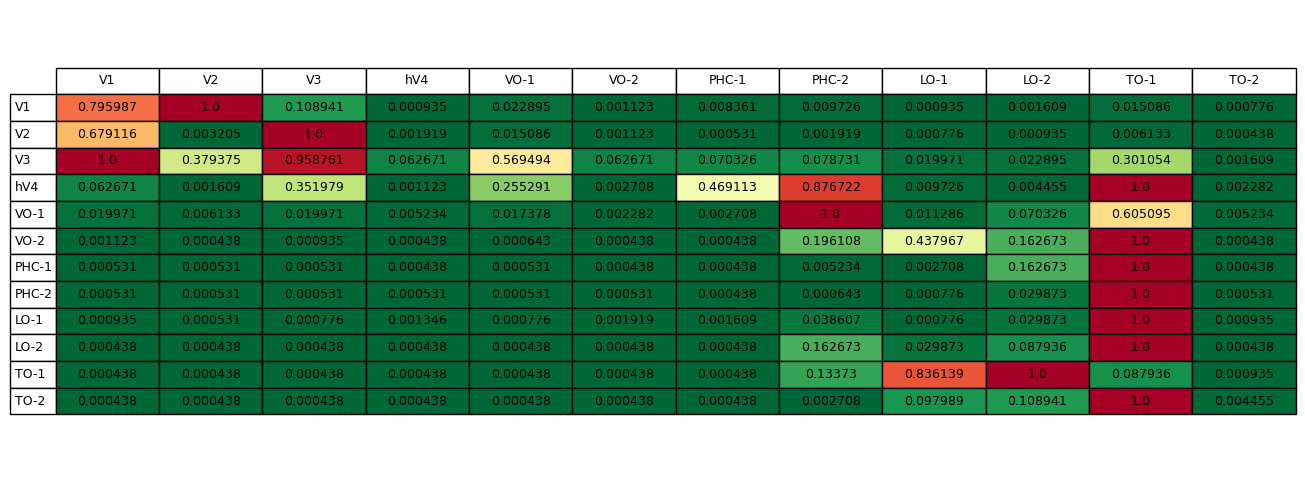

In [19]:
df = p_df.apply(pd.to_numeric)
norm = plt.Normalize(df.values.min(), df.values.max())

# Create a custom colormap
cmap = plt.get_cmap('RdYlGn')

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Create a table with colored cells
cell_colors = cmap(1-norm(df.values))

# Add table to the axes
table = ax.table(cellText=df.values.round(6),
                 rowLabels=df.index,
                 colLabels=df.columns,
                 cellColours=cell_colors,
                 cellLoc='center',
                 loc='center')

# Customize the table appearance
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.6, 1.6)

# Display the plotS
plt.show()

In [1]:
oself_V1 = [average_test_var_explain_lh_subj01, average_test_var_explain_rh_subj02.....] = 16 
best_roi_V1 = [average_test_var_explain_lh_subj01, average_test_var_explain_rh_subj02.....] = 16 

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2473606024.py, line 1)

## CHECK IF THE MODEL CREATION THING IS DOING THE RIGHT THING. NP UNIQUE ON THE LAST COL SHOULD BE ['LO-1' 'TO-1' 'TO-2' 'V1' 'V3' 'hV4']

In [86]:
check = os.path.join(models_dir, 'best_fits_best_roi_wself_subj01_train.npy')
check = np.load(check, allow_pickle=True)
pd.DataFrame(check)

,0,1,2,3,4,5,6,7,8,9,10
0,1.05,-0.614549,10.020156,42.372829,-42.054451,0.015312,0.075056,1.484924,2.100326,V1,V2
1,-0.103111,1.05,0.092584,0.131936,-0.00714,-0.000048,0.00017,1.055051,-0.097887,V1,V2
2,1.05,-0.555147,8.668568,30.163055,-29.861687,0.01356,0.068791,1.484924,2.057148,V1,V2
3,1.05,-0.614838,11.921257,56.740578,-56.4384,0.013866,0.068399,1.484924,2.100531,V1,V2
4,0.914611,-0.605089,10.992586,52.497631,-52.226624,0.011115,0.062071,1.392485,2.15527,V1,V2
...,...,...,...,...,...,...,...,...,...,...,...
33792,0.603613,-0.566574,5.597074,18.109232,-17.884701,0.005802,0.044219,1.211135,2.324553,V1,V2
33793,-0.418892,-0.033262,7.520882,79.781555,-79.346634,0.064343,0.159955,0.486836,-1.650034,V2,V3
33794,-0.612212,0.192005,8.432076,65.462936,-65.087265,0.058183,0.119394,0.660563,-1.266887,V2,V3
33795,-0.443189,-0.142724,7.779343,90.307274,-89.826004,0.073751,0.189057,0.507893,-1.882348,V2,V3


In [87]:
np.unique(check[:, -1])

array(['LO-2', 'PHC-2', 'TO-1', 'V1', 'V2', 'V3'], dtype=object)

In [15]:
subj01_results = pd.DataFrame(results_both_hemis[1], columns=rois.keys(), index=rois.keys())
subj01_results["best_roi"]  = subj01_results.idxmax(axis=1)
print(np.unique(subj01_results["best_roi"]))
subj01_results

['LO-1' 'TO-1' 'TO-2' 'V1' 'V3' 'hV4']


,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2,best_roi
V1,0.054127,0.018787,0.020574,0.014294,0.002971,-0.003215,-0.005333,-0.002084,0.002582,-0.004891,-0.003283,-0.002925,V1
V2,0.057340,-1.000000,0.022865,0.003796,0.004268,-0.003892,-0.002609,0.001120,-0.000669,-0.001306,0.003177,0.000554,V1
V3,0.023574,0.031343,-1.000000,0.035251,0.004707,0.000258,-0.004481,-0.000631,0.002640,-0.002583,-0.004028,-0.002940,hV4
hV4,0.021588,0.019198,0.019675,-1.000000,-0.005416,-0.007551,-0.007219,-0.003863,0.011522,-0.001024,-0.004750,-0.003285,V1
VO-1,0.020529,0.022031,0.026052,0.038434,-1.000000,0.000828,-0.001900,0.002494,0.007523,-0.001213,-0.003349,-0.001724,hV4
VO-2,0.032614,0.022989,0.034706,0.008469,0.003559,-1.000000,-0.004447,-0.001502,0.019165,0.005300,-0.000514,-0.002332,V3
PHC-1,0.016565,0.016803,0.023664,0.062324,0.013889,0.004868,-1.000000,0.002690,0.004272,-0.001348,0.000655,-0.000802,hV4
PHC-2,0.011709,0.005612,0.010892,0.023945,0.060820,0.039860,0.038795,-1.000000,0.016164,0.011687,0.061348,0.041765,TO-1
LO-1,0.010074,0.007488,0.010650,0.016560,0.045119,0.055389,0.048851,0.061536,-1.000000,0.016749,0.062513,0.056477,TO-1
LO-2,0.006085,0.003252,0.005699,0.007293,0.038482,0.041907,0.049517,0.059009,0.024158,-1.000000,0.067339,0.060524,TO-1
